# Business Understanding

## Business Objective

- **Business Objective:** A smartphone consortium led by Apple and Google want to prove via a 2-week proof-of-concept whether Twitter data can be used to detect
sentiment with the highly desirable consumers at SXSW.


- **Requirements:**
    - Develop predictive model to classify tweet sentiment
    - Explain performance and any limitations for positive and negative model predictions
    - Suggest potential solutions to evolve beyond a POC model


- **Data Source:** Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. 
Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093 Tweets

https://data.world/crowdflower/brands-and-product-emotions 

## Executive Summary

A short executive summary presentation can be found 
<a href="https://github.com/cutterback/p04-twitter-sentiment-nlp/blob/2e65c792fe16bcd162b053ff61f23ca6f35d46de/Tweet_Sentiment_Analysis_Exec_Summary.pdf">at this link</a> 


- Performance of our best POC model is not sufficient
- Best POC Model performance:
    - Overall Accuracy
        - Model predicted correctly 69% of time
        - Best performance on neutral tweets    
    - Negative Tweets
        - When predicted, right only 38% of time
        - Able to predict only 23% of true negatives
    - Positive Tweets
        - When predicted, right 64% of time
        - Able to predict 55% of true negatives
- **Conclusion**: Proof-of-Concept effort shows promise but falls short of usability


- **Phase 1 Improvement Ideas**: We recommend investing in a Phase 1 project to improve predictive accuracy but addressing these shortcomings in the POC model:
    - Data – Greatly increase tweet sample size from 9K (only 6% were negative)
    - Use Case – Work backwards from specific use case goals (actions) to identify tweet patterns
    - Sentiment Scoring – In addition to human labeling, automate word sentiment scoring
    - Improve Models – Deeper exploration of parameter tuning in predictive models

# Data Engineering

## Import Libraries

In [38]:
# import libraries required to load, transform, analyze and model data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)
from collections import Counter
import string
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import en_core_web_sm
from spacy.tokenizer import _get_regex_pattern
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from keras.preprocessing import text, sequence
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as k
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Dataframe Basics

### Load File

In [3]:
# load primary source file to df, renaming columns, dropping non-ASCII
col_names = ['tweet_text', 'directed_at', 'emotion_label']
tweets = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape', names=col_names, header=0)
tweets.head()

,tweet_text,directed_at,emotion_label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### Data Values

In [4]:
# review data types and null counts
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_text     9092 non-null   object
 1   directed_at    3291 non-null   object
 2   emotion_label  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# drop nan tweets from dataframe
tweets.dropna(subset = ['tweet_text'], inplace=True)
tweets.shape

(9092, 3)

In [6]:
# check value counts by directed_at
print(tweets['directed_at'].value_counts(normalize=True, dropna=False))

NaN                               0.638
iPad                              0.104
Apple                             0.073
iPad or iPhone App                0.052
Google                            0.047
iPhone                            0.033
Other Google product or service   0.032
Android App                       0.009
Android                           0.009
Other Apple product or service    0.004
Name: directed_at, dtype: float64


In [7]:
# create brand feature, mapping directed_at to Apple, Google or None
tweets['directed_at'].fillna('None', inplace=True)
brand_map = {'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
             'Google': 'Google', 'iPhone': 'Apple', 
             'Other Google product or service': 'Google',
            'Android App': 'Google', 'Android': 'Google',
             'Other Apple product or service': 'Apple',
             'None': 'None'
            }
tweets['brand'] = tweets.directed_at.map(brand_map, na_action='ignore')

In [8]:
# simplify emotion labels to Positive, Negative or Neutral
tweets['emotion_label'].replace({'No emotion toward brand or product': 'Neutral',
                                 'Positive emotion': 'Positive', 
                                 'Negative emotion': 'Negative', 
                                 'I can\'t tell': 'Unknown'}, inplace=True)

# check value distribution by emotion
print(tweets['emotion_label'].value_counts(normalize=True, dropna=False))

Neutral    0.593
Positive   0.328
Negative   0.063
Unknown    0.017
Name: emotion_label, dtype: float64


In [9]:
# check value distribution by emotion witin brand
tweets.groupby(by=['brand', 'emotion_label'])['tweet_text'].count()

brand   emotion_label
Apple   Negative          388
        Neutral            65
        Positive         1949
        Unknown             7
Google  Negative          131
        Neutral            26
        Positive          723
        Unknown             2
None    Negative           51
        Neutral          5297
        Positive          306
        Unknown           147
Name: tweet_text, dtype: int64

**Notes on Data**
- Given only 9K samples, with less than half having brand affilication, I am choosing to use the entire data set without consideration of brand or device as the POC model
- Larger samples would be required to reliably train at the brand level

## Tweet Text Clean

In [10]:
def remove_punctuation(x):
    """
    Helper function removes punctuation, numbers, urls, and @mentions from a 
    string. Leaves hastags in place.
    
    Parameter | x (str): text string of any length
    Returns | x (str): same string cleaned
    """
    punctuation = set(string.punctuation) # set of punctuation - english
    punctuation.remove('#') # remove "#" so hashtags remain in tweet text

    x = re.sub('@[A-Za-z0-9]+', '', x) # remove @mention users
    x = re.sub(r'http\S+', '', x) # remove url references
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    return x

In [11]:
def clean_text(df, text_field, new_text_field):
    """
    Function inserts a new DataFrame series with punctuation removed while 
    retaining original series.
    
    Parameter | df (DataFrame): dataframe
    Parameter | text_field (Series): column to transform
    Parameter | new_text_field (Series): new, cleaned column    
    Returns | df (DataFrame): dataframe with new column
    """
    df[new_text_field] = df[text_field].str.lower()
    df[new_text_field] = df[new_text_field].apply(remove_punctuation) 
    return df

In [12]:
# create new dataframe with cleaned tweet text
tweets_clean = clean_text(tweets, 'tweet_text', 'tweet_text_clean')
tweets_clean.head()

,tweet_text,directed_at,emotion_label,brand,tweet_text_clean
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress


In [13]:
# instantiate spacy natural language processing object
nlp = en_core_web_sm.load()

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)

# add my patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the spacy tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

In [14]:
# create tokens_sp with word lemmas as tokens, striped of stopwords
stops_sp = nlp.Defaults.stop_words
print(f'spaCy Stopword Count: {len(stops_sp)}')

def clean_token(doc):
    return [token.lemma_ for token in doc if not token.is_stop 
            and not token.is_punct and not token.is_digit 
            and not token.is_space]

tweets['tokens_sp'] = [clean_token(nlp(row)) for row in tweets.tweet_text_clean.apply(str)]

tweets.head()

spaCy Stopword Count: 326


,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,"[know, awesome, ipadiphone, app, will, likely, appreciate, design, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw,"[wait, #ipad, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[great, stuff, fri, #sxsw, marissa, mayer, google, tim, oreilly, tech, booksconference, amp, matt, mullenweg, wordpress]"


In [15]:
# create dictionary of token counts and print top 10
word_dict = {}

# Loop through all the tags
for i, row in tweets['tokens_sp'].iteritems():
    for word in row:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] +=1

word_counts = sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True)
print(f'Total words: {len(word_counts)}')
word_counts[:10]

Total words: 9533


[('#sxsw', 8947),
 ('link', 4300),
 ('rt', 2953),
 ('ipad', 2245),
 ('google', 2102),
 ('apple', 1826),
 ('store', 1501),
 ('iphone', 1258),
 ('new', 1093),
 ('app', 992)]

## Tweet Cloud

In [16]:
# importing twitter logo images as mask for wordcloud
twitter_mask = np.array(Image.open('images/twitter_mask.png'))

In [17]:
# pivot full words from negative and positive tweets into new series
neg_tweets = (tweets[tweets.emotion_label == 'Negative']
              .tokens_sp
              .apply(pd.Series)
              .stack()
              .reset_index(drop = True)
             )
pos_tweets = (tweets[tweets.emotion_label == 'Positive']
              .tokens_sp
              .apply(pd.Series)
              .stack()
              .reset_index(drop = True)
             )

In [18]:
# isolate word sets that are uniquely associated to negative or positive tweets
neg_words_set = set(neg_tweets)-set(pos_tweets)
pos_words_set = set(pos_tweets)-set(neg_tweets)

In [19]:
# filter full words from negative or positive tweets against sets
# retains all occurences of uniquely negative or positive words to feed wordcloud
neg_words_list = neg_tweets[neg_tweets.isin(neg_words_set)==True]
neg_words_list = ' '.join(word for word in neg_words_list)
pos_words_list = pos_tweets[pos_tweets.isin(pos_words_set)==True]
pos_words_list = ' '.join(word for word in pos_words_list)

**Notes on WordCloud**
- Initially using all words found in positive and negative tweets resulted in mostly similar words appearing.
- To make word clouds more intuitive, they are shown with isolating only words found uniquely for positive or negative tweets.

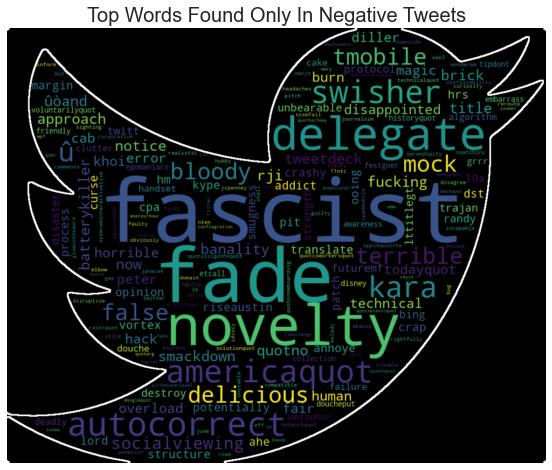

In [20]:
# generating a wordcloud with a twitter mask for negative words only 
wordcloud1 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud1.generate(neg_words_list)

plt.figure(figsize = (10, 8), facecolor = 'white') 
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Top Words Found Only In Negative Tweets', size=20)
plt.axis('off')
plt.show()

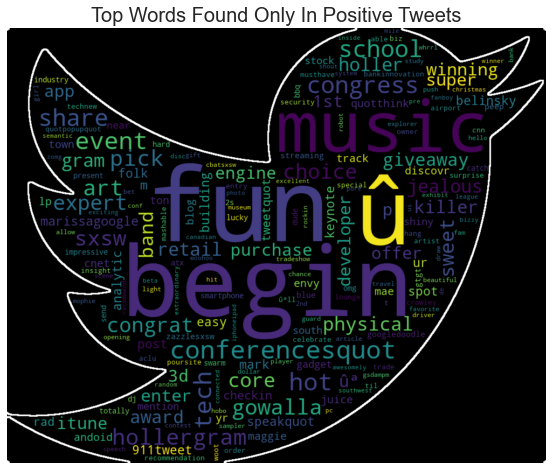

In [21]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud2 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud2.generate(pos_words_list)

plt.figure(figsize = (10, 8), facecolor = 'white') 
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Top Words Found Only In Positive Tweets', size=20)
plt.axis('off')
plt.show()

# Predictive Models

## Train-Test Split

In [22]:
# filter tweets for identifiable emotions only (drop unknown)
SEED = 19
sentiments = ['Positive', 'Negative', 'Neutral']
tweets_f = tweets[tweets['emotion_label'].isin(sentiments)]

# create X and y (one-hot encoded for 3 classes)
Xt = tweets_f['tokens_sp'] # Xt contains spacy lemma tokens without stops
X = tweets_f['tweet_text_clean'] # X contains cleaned full text with stops
y = pd.get_dummies(tweets_f['emotion_label'])
print(X.iloc[:3], y.iloc[:3])

0           i have a 3g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw
1     know about   awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2                                                        can not wait for #ipad  also they should sale them down at #sxsw
Name: tweet_text_clean, dtype: object    Negative  Neutral  Positive
0         1        0         0
1         0        0         1
2         0        0         1


In [23]:
def TrainTestSplit(X, y):
    """
    For LSTM models, converts X to tokens, sequenced with padding, retaining 
    original indicies. Splits X and y into train and test datasets with 
    y stratification. Computes a few paramters for LSTM model.
    
    Parameter | X (Series): predictor text
    Parameter | y (Series): target ohe emotions 
    Returns | tokenizer object, X/y train/test sets, LSTM parameters: 
    doc_cnt, vocab_size and input_length
    """
    # keras tokenize sequences with padding, retain index
    t = text.Tokenizer(oov_token=1)
    t.fit_on_texts(X)
    X_seq = t.texts_to_sequences(X)
    X_seq_pad = sequence.pad_sequences(X_seq, padding='post') 
    X_seq_df = pd.DataFrame(data=X_seq_pad, index=X.index.copy())
   
    # Split into training and test sets for cleaned text
    SEED = 19
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq_df, y, test_size=0.20, stratify=y, random_state=SEED)

    print(f'X_train: {X_train.shape} X_test: {X_test.shape} ' 
          f'y_train: {y_train.shape} y_test: {y_test.shape}')

    # set parameters for LSTM model input
    doc_cnt = X_train.shape[0]
    vocab_size = len(t.word_index)+1
    input_length = X_train.shape[1]

    print(f'Document count: {doc_cnt} | '
          f'Vocab size: {vocab_size} | '
          f'Input length: {input_length} '
         )
    return t, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, input_length

In [24]:
# create train/test for LSTM models (m1-m3) - cleaned full text with stops (X)
X_tok, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, \
    input_length = TrainTestSplit(X, y)

X_train: (7148, 30) X_test: (1788, 30) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 10565 | Input length: 30 


In [25]:
# create train/test for LSTM models (m1-m3) - spacy lemma tokens without stops (Xt)
Xt_tok, Xt_train, Xt_test, yt_train, yt_test, doc_cnt2, vocab_size2, \
    input_length2 = TrainTestSplit(Xt, y)

X_train: (7148, 23) X_test: (1788, 23) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 9435 | Input length: 23 


## Model Functions

In [26]:
def plot_accuracy(history, model_name):
    """
    For keras models, plots accuracy for train vs. validation by epoch.
    
    Parameter | history (dict): history results of fitted sequential model
    Parameter | model name (keras sequential model object): fitted model 
    Returns | none
    """
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accuracy: {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [27]:
def predict(model, X):
    """
    For keras fitted models, predicts target probabilities and absolute class
    based on series X retaining pandas indicies.
    
    Parameter | model (keras sequential model object): fitted model 
    Parameter | X: sequenced text for train or test
    Returns | y_hat: raw probabilities for multi-label columns,
              y_hat_cl: decision function for multi-label columns (0/1)
    """
    classes = ['Negative', 'Neutral', 'Positive']
    y_hat = model.predict(X)
    
    y_hat_cl = pd.DataFrame((y_hat == y_hat.max(axis=1, 
                                                keepdims=True)).astype(int), 
                                                columns=classes,
                                                index=X.index.copy())
    
    y_hat = pd.DataFrame(y_hat,columns=classes, index=X.index.copy())
    
    return y_hat, y_hat_cl

In [28]:
def pivot_predictions(neg, neut, pos):
    """
    Evaluates 3 boolean values (0/1) and returns predicted class as Negative,
    Neutral or Positive
    
    Parameters | neg, neut, pos (int): 0/1 values
    Returns | pred_class (str): string as Negative, Neutral, Positive, Unknown
    """        
    pred_class = 'Unknown'
    if neg == 1:
        pred_class = 'Negative'
    elif neut == 1:
        pred_class = 'Neutral'
    elif pos == 1:
        pred_class = 'Positive'
    return pred_class

In [29]:
def create_pred_class(y):
    """
    Takes multi-label target (y) and creates new single columns with 
    predicted class for use with confusion matrix
    
    Parameter | y (DataFrame): targets with decision function applied (0/1)
    Returns | y_piv (DataFrame): same as input with pred_class column added
    """    
    y_piv = y.copy()
    y_piv['pred_class'] = y_piv.apply(lambda row: 
                                      pivot_predictions(row.Negative, 
                                                        row.Neutral, 
                                                        row.Positive), 
                                      axis=1)
    return y_piv

In [30]:
def plot_confusion(typ, y_true, y_hat, model_name):  
    """
    Computes and plots confusion matrix comparing predicted and actual 
    target classes. Also prints classification report.
    
    Parameters | y_true (Series): actual target classes
    Parameters | y_hat (Series): predicted targe classes
    Returns | cnf_matrix (array): confusion matrix results
    """    
    cnf_matrix  = confusion_matrix(y_true, y_hat)
    cmap = plt.get_cmap('Blues')
    cmd = ConfusionMatrixDisplay(cnf_matrix,  
                                 display_labels=['Negative', 'Neutral', 
                                                 'Positive'])
    
    cmd.plot(cmap=cmap)
    plt.title(f'{typ} Confusion Matrix for Model: {model_name}')
    plt.tight_layout()
    plt.show()
    print(classification_report(y_true, y_hat))
    return cnf_matrix

## m0 - SVM Baseline

In [31]:
# create baseline support vector machines model, split train/text
SEED = 19
y_m0 = tweets_f['emotion_label']
X_train_m0, X_test_m0, y_train_m0, y_test_m0 = train_test_split(X, y_m0, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=SEED)

In [32]:
# create tfidf vectors for train and test
vectorizer = TfidfVectorizer(stop_words='english')
train_vectors = vectorizer.fit_transform(X_train_m0)
test_vectors = vectorizer.transform(X_test_m0)

In [33]:
# instantiate and fit the svc model using balance class weights
svc = SVC(kernel='linear', class_weight='balanced')
svc.fit(train_vectors, y_train_m0)

SVC(class_weight='balanced', kernel='linear')

In [34]:
# use svc model to predict based on train
y_train_hat_m0 = svc.predict(train_vectors)

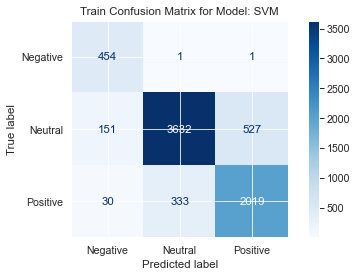

              precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       456
     Neutral       0.92      0.84      0.88      4310
    Positive       0.79      0.85      0.82      2382

    accuracy                           0.85      7148
   macro avg       0.81      0.90      0.84      7148
weighted avg       0.86      0.85      0.86      7148



In [39]:
# plot train confusion matrix and classification report for svm
cnf_matrix_train_m0 = plot_confusion('Train', y_train_m0, y_train_hat_m0,'SVM')

In [40]:
# use svc model to predict based on test
y_test_hat_m0 = svc.predict(test_vectors)

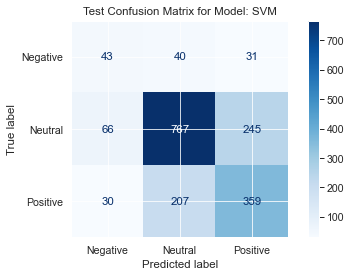

              precision    recall  f1-score   support

    Negative       0.31      0.38      0.34       114
     Neutral       0.76      0.71      0.73      1078
    Positive       0.57      0.60      0.58       596

    accuracy                           0.65      1788
   macro avg       0.54      0.56      0.55      1788
weighted avg       0.66      0.65      0.66      1788



In [41]:
# plot train confusion matrix and classification report for svm
cnf_matrix_test_m0 = plot_confusion('Test', y_test_m0, y_test_hat_m0, 'SVM')

## m1 - LSTM Embed Tweets Cleaned

In [42]:
# instantiate keras 6-layer sequential LSTM model layers with embeddings
m1 = Sequential(name="m1_seq_lstm")
m1.add(Embedding(input_dim=vocab_size, 
                    output_dim=128, 
                    input_length=input_length
                    ))
m1.add(LSTM(64, return_sequences=True))
m1.add(GlobalMaxPool1D()) # downsamples input takes max value over time dimension
m1.add(Dropout(0.15)) # drop out for regularization
m1.add(Dense(32, activation='relu'))
m1.add(Dense(3, activation='softmax'))

In [43]:
# compile model 1 and print summary
m1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m1.summary()

Model: "m1_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 128)           1352320   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,403,907
Trainable params: 1,403,907
Non-trainable params: 0
_____________________________________________

In [44]:
# Define the callbacks, early stopping and save final model 1
early_stop_m1 = [EarlyStopping(monitor='val_loss', patience=3, 
                               restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m1.h5', 
                                  monitor='val_loss',
                                  save_best_only=True)]

# set class weights close to balanced (amplify negative 9x and positive 2x)
class_weights_m1 = [{0: 1, 1: 9}, {0: 1, 1: 1}, {0: 1, 1: 2}]

# fit model 1 with 15% validation split
m1_fit = m1.fit(X_train, y_train, epochs=50, callbacks=early_stop_m1, 
                class_weight=class_weights_m1, validation_split=0.15, 
                shuffle=True, batch_size=128)

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 10s 2ms/step - loss: 0.9060 - accuracy: 0.5923 - val_loss: 0.8396 - val_accuracy: 0.5983
Epoch 2/50
6075/6075 [==============================] - 9s 1ms/step - loss: 0.7820 - accuracy: 0.6495 - val_loss: 0.7491 - val_accuracy: 0.6626
Epoch 3/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.5931 - accuracy: 0.7681 - val_loss: 0.7349 - val_accuracy: 0.6859
Epoch 4/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.4100 - accuracy: 0.8469 - val_loss: 0.7696 - val_accuracy: 0.6822
Epoch 5/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.2983 - accuracy: 0.8866 - val_loss: 0.7892 - val_accuracy: 0.6915
Epoch 6/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.2442 - accuracy: 0.9088 - val_loss: 0.8974 - val_accuracy: 0.6971


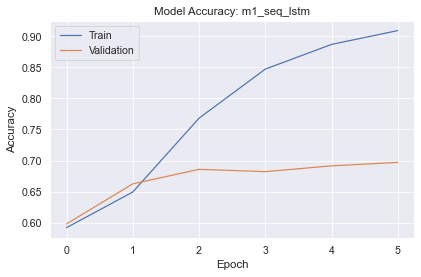

In [45]:
# extract history from model 1 and plot epoch accuracy trend
m1_hist = m1_fit.history
plot_accuracy(m1_hist, m1.name)

In [47]:
# create predictions for model (train)
y_train_hat_m1, y_train_hat_cl_m1 = predict(m1, X_train)

In [48]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_train_piv = create_pred_class(y_train)
y_train_hat_cl_m1_piv = create_pred_class(y_train_hat_cl_m1)

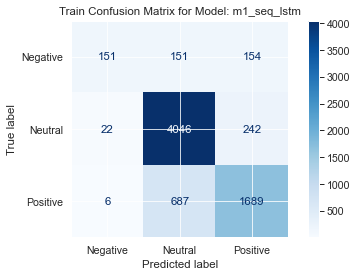

              precision    recall  f1-score   support

    Negative       0.84      0.33      0.48       456
     Neutral       0.83      0.94      0.88      4310
    Positive       0.81      0.71      0.76      2382

    accuracy                           0.82      7148
   macro avg       0.83      0.66      0.70      7148
weighted avg       0.82      0.82      0.81      7148



In [49]:
# plot confusion matrix and classification report
cnf_matrix_train_m1 = plot_confusion('Train', y_train_piv.pred_class, 
                               y_train_hat_cl_m1_piv.pred_class,
                               m1.name)

In [50]:
# concatenate predictions with actual target class and tweets for sanity check
Xy_train_m1 = pd.concat([y_train_piv.iloc[:, 3], 
                         y_train_hat_cl_m1_piv.iloc[:, 3], 
                         y_train_hat_m1, X], axis=1, join='inner')
Xy_train_m1.columns.values[0] = 'act_class'
Xy_train_m1.columns.values[2] = 'p_negative'
Xy_train_m1.columns.values[3] = 'p_neutral'
Xy_train_m1.columns.values[4] = 'p_positive'
Xy_train_m1

,act_class,pred_class,p_negative,p_neutral,p_positive,tweet_text_clean
6929,Neutral,Neutral,0.009,0.946,0.045,rt who is flying to #sxsw and wants some free miles dm meill shoot you a code currently iphone only
5841,Neutral,Neutral,0.014,0.926,0.060,rt google launching secret new social network called quotcirclesquot link #sxsw
2865,Negative,Negative,0.448,0.300,0.251,google prefers to launch hyped new social features with meh not bang via tc link #sxsw
4306,Neutral,Neutral,0.020,0.883,0.097,luv rt best thing i heard this wknd at #sxsw quoti gave my ipad money to #japan relief dont need ipad quot
8888,Positive,Positive,0.018,0.150,0.831,i wish i were at #sxsw i wish i had an ipad there i said it
...,...,...,...,...,...,...
4594,Neutral,Neutral,0.041,0.901,0.059,money money money #apple heads to #sxsw sets up temporary store in austin link via
6975,Neutral,Neutral,0.023,0.639,0.338,rt wow leo just told a random person on the street he would send her an ipad #twit #sxsw
7700,Neutral,Neutral,0.285,0.556,0.159,false alarm google circles not coming nowûòand probably not ever link more link #sxsw #sxswi
1476,Positive,Positive,0.014,0.479,0.507,brilliant rt apple set to open popup shop in core of sxsw action theyre going to sell ipad2 at #sxsw link


In [52]:
# create test predictions for model
y_test_hat_m1, y_test_hat_cl_m1 = predict(m1, X_test)

In [53]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_test_piv = create_pred_class(y_test)
y_test_hat_cl_m1_piv = create_pred_class(y_test_hat_cl_m1)

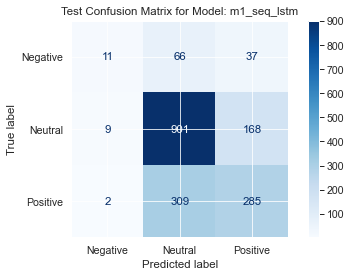

              precision    recall  f1-score   support

    Negative       0.50      0.10      0.16       114
     Neutral       0.71      0.84      0.77      1078
    Positive       0.58      0.48      0.52       596

    accuracy                           0.67      1788
   macro avg       0.60      0.47      0.48      1788
weighted avg       0.65      0.67      0.65      1788



In [54]:
# plot tes confusion matrix and classification report
cnf_matrix_test_m1 = plot_confusion('Test', y_test_piv.pred_class, 
                               y_test_hat_cl_m1_piv.pred_class,
                               m1.name)

## m2 - LSTM Embed Tweet Tokens

In [56]:
# instantiate same model as model 1 but on lemma tokens vs. cleaned full text
m2 = Sequential(name="m2_seq_lstm")
m2.add(Embedding(input_dim=vocab_size2, 
                    output_dim=128, 
                    input_length=input_length2
                    ))
m2.add(LSTM(64, return_sequences=True))
m2.add(GlobalMaxPool1D()) # downsamples input takes max value over time dimension
m2.add(Dropout(0.15)) # drop out for regularization
m2.add(Dense(32, activation='relu'))
m2.add(Dense(3, activation='softmax'))

In [57]:
# compile model 2 and print summary
m2.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m2.summary()

Model: "m2_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 128)           1207680   
_________________________________________________________________
lstm_3 (LSTM)                (None, 23, 64)            49408     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,259,267
Trainable params: 1,259,267
Non-trainable params: 0
_____________________________________________

In [58]:
# Define the callbacks, early stopping and save final model
early_stop_m2 = [EarlyStopping(monitor='val_loss', patience=3, 
                            restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m2.h5', 
                                  monitor='val_loss',
                                  save_best_only=True)]

# set class weights overweight 2x (amplify negative 20x and positive 4x)
class_weights_m2 = [{0: 1, 1: 20}, {0: 1, 1: 1}, {0: 1, 1: 4}]

# fit model 2 with 15% validation split (same paramters model 1)
m2_fit = m2.fit(Xt_train, yt_train, epochs=50, callbacks=early_stop_m2,
          class_weight=class_weights_m2, validation_split=0.15, 
                shuffle=True, batch_size=128)

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.8919 - accuracy: 0.5988 - val_loss: 0.8473 - val_accuracy: 0.5983
Epoch 2/50
6075/6075 [==============================] - 6s 1ms/step - loss: 0.7928 - accuracy: 0.6217 - val_loss: 0.7924 - val_accuracy: 0.6011
Epoch 3/50
6075/6075 [==============================] - 6s 1ms/step - loss: 0.6206 - accuracy: 0.7379 - val_loss: 0.7327 - val_accuracy: 0.6757
Epoch 4/50
6075/6075 [==============================] - 6s 1ms/step - loss: 0.4371 - accuracy: 0.8316 - val_loss: 0.7953 - val_accuracy: 0.6654
Epoch 5/50
6075/6075 [==============================] - 6s 1ms/step - loss: 0.3234 - accuracy: 0.8757 - val_loss: 0.8631 - val_accuracy: 0.6766
Epoch 6/50
6075/6075 [==============================] - 6s 1ms/step - loss: 0.2734 - accuracy: 0.8973 - val_loss: 0.8609 - val_accuracy: 0.6692


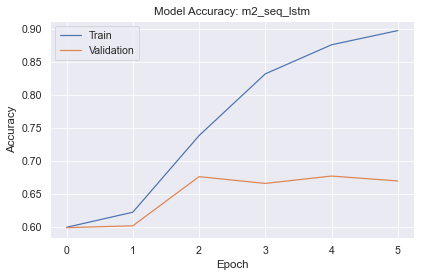

In [59]:
# extract history from model 2 and plot epoch accuracy trend
m2_hist = m2_fit.history
plot_accuracy(m2_hist, m2.name)

In [60]:
# create predictions for model 2
yt_train_hat_m2, yt_train_hat_cl_m2 = predict(m2, Xt_train)

In [61]:
# pivot 3 multi-labels into single class column to feed confusion matrix
yt_train_piv = create_pred_class(yt_train)
yt_train_hat_cl_m2_piv = create_pred_class(yt_train_hat_cl_m2)

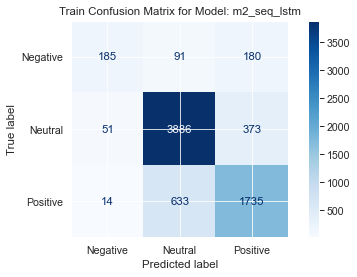

              precision    recall  f1-score   support

    Negative       0.74      0.41      0.52       456
     Neutral       0.84      0.90      0.87      4310
    Positive       0.76      0.73      0.74      2382

    accuracy                           0.81      7148
   macro avg       0.78      0.68      0.71      7148
weighted avg       0.81      0.81      0.81      7148



In [62]:
# plot train confusion matrix and classification report
cnf_matrix_train_m2 = plot_confusion('Train', yt_train_piv.pred_class, 
                               yt_train_hat_cl_m2_piv.pred_class,
                               m2.name)

In [63]:
# create test predictions for model 2
y_test_hat_m2, y_test_hat_cl_m2 = predict(m2, Xt_test)

In [64]:
# pivot 3 multi-labels into single class column to feed confusion matrix
yt_test_piv = create_pred_class(yt_test)
y_test_hat_cl_m2_piv = create_pred_class(y_test_hat_cl_m2)

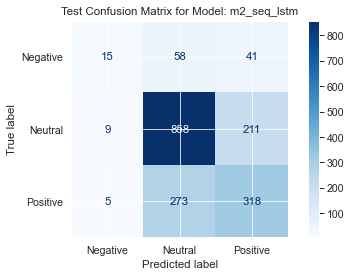

              precision    recall  f1-score   support

    Negative       0.52      0.13      0.21       114
     Neutral       0.72      0.80      0.76      1078
    Positive       0.56      0.53      0.55       596

    accuracy                           0.67      1788
   macro avg       0.60      0.49      0.50      1788
weighted avg       0.65      0.67      0.65      1788



In [65]:
# plot test confusion matrix and classification report
cnf_matrix_test_m2 = plot_confusion('Test', yt_test_piv.pred_class, 
                               y_test_hat_cl_m2_piv.pred_class,
                               m2.name)

## m3 - LSTM Embed Glove

In [66]:
# establish total vocabulary prior to fetching Glove vectors
t0 = text.Tokenizer(oov_token=1)
t0.fit_on_texts(X)
vocab = list(t0.word_counts.keys())
print(f'Total tweet vocabulary is: {len(vocab)}')

Total tweet vocabulary is: 10563


In [67]:
# create gloVe twitter dictionary of embedding vectors for vocab list
glove_file = 'data/glove.twitter.27B.200d.txt'
glove = {}
with open(glove_file, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [69]:
# create gloVe embedding matrix for use by embedding layer
glove_dim = len(next(iter(glove.values())))  

emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in X_tok.word_index.items():
    vect = glove.get(w)
    if vect is not None:
        emb_matrix[i] = vect

In [70]:
# instantiate sequential bi-directional LSTM model w/ 8-layers and gloVe embeds
m3 = Sequential(name="m3_seq_lstm_glove")
m3.add(Embedding(input_dim=vocab_size, 
                 output_dim=glove_dim, 
                 input_length=input_length,
                 weights=[emb_matrix], 
                 trainable=False
                    ))
m3.add(SpatialDropout1D(0.2))
m3.add(LSTM(128, return_sequences=True))
m3.add(Bidirectional(LSTM(128, dropout=0.15, recurrent_dropout=0.15, return_sequences=True)))
m3.add(GlobalMaxPool1D())
m3.add(Dense(64, activation="relu")) 
m3.add(Dense(32, activation="relu"))
m3.add(Dense(3, activation='softmax'))

**Notes on Model 3 Layers**
- Going beyond standard Model 1/2 layers
- Using Twitter gloVe embeddings
- Includes a spatialdropout1D layer to start
- Includes LSTM and bidirectional LSTM layer
- Still includes GlobalMaxPool1D, but also now two Dense relu layers.

In [71]:
# compile model 3 and print summary
opt = optimizers.Adam(learning_rate=0.001) 
m3.compile(loss='categorical_crossentropy', optimizer=opt,
              metrics=['accuracy'])
m3.summary()

Model: "m3_seq_lstm_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 200)           2113000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           168448    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 32)          

In [72]:
# Define the callbacks, early stopping and save final model
early_stop_m3 = [EarlyStopping(monitor='val_loss', patience=3, 
                               restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m3.h5', 
                                  monitor='val_loss',
                                  save_best_only=True)]

# set class weights to 2x overweight (amplify negative 20x and positive 4x)
class_weights_m3 = [{0: 1, 1: 20}, {0: 1, 1: 1}, {0: 1, 1: 4}]

# fit model 3 with 15% validation split 
m3_fit = m3.fit(X_train, y_train, epochs=50, class_weight=class_weights_m3,
                callbacks=early_stop_m3, validation_split=0.15, shuffle=True,
                batch_size=128)

Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 33s 5ms/step - loss: 0.8669 - accuracy: 0.5870 - val_loss: 0.8098 - val_accuracy: 0.6011
Epoch 2/50
6075/6075 [==============================] - 28s 5ms/step - loss: 0.7855 - accuracy: 0.6217 - val_loss: 0.7544 - val_accuracy: 0.6300
Epoch 3/50
6075/6075 [==============================] - 28s 5ms/step - loss: 0.7523 - accuracy: 0.6372 - val_loss: 0.7197 - val_accuracy: 0.6468
Epoch 4/50
6075/6075 [==============================] - 28s 5ms/step - loss: 0.7155 - accuracy: 0.6604 - val_loss: 0.6917 - val_accuracy: 0.6813
Epoch 5/50
6075/6075 [==============================] - 27s 5ms/step - loss: 0.6962 - accuracy: 0.6779 - val_loss: 0.6827 - val_accuracy: 0.6813
Epoch 6/50
6075/6075 [==============================] - 27s 4ms/step - loss: 0.6664 - accuracy: 0.6891 - val_loss: 0.6469 - val_accuracy: 0.6841
Epoch 7/50
6075/6075 [==============================] - 27s 4ms/step - loss: 0.638

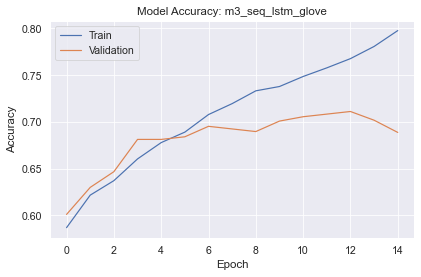

In [73]:
# extract history from model 3 and plot epoch accuracy trend
m3_hist = m3_fit.history
plot_accuracy(m3_hist, m3.name)

In [74]:
# create predictions for model 3
y_train_hat_m3, y_train_hat_cl_m3 = predict(m3, X_train)

In [75]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_train_piv = create_pred_class(y_train)
y_train_hat_cl_m3_piv = create_pred_class(y_train_hat_cl_m3)

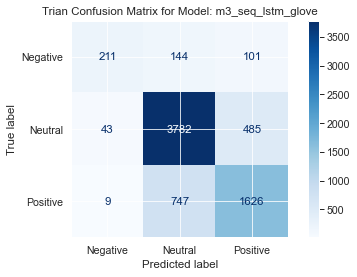

              precision    recall  f1-score   support

    Negative       0.80      0.46      0.59       456
     Neutral       0.81      0.88      0.84      4310
    Positive       0.74      0.68      0.71      2382

    accuracy                           0.79      7148
   macro avg       0.78      0.67      0.71      7148
weighted avg       0.78      0.79      0.78      7148



In [76]:
# plot train confusion matrix and classification report
cnf_matrix_train_m3 = plot_confusion('Trian', y_train_piv.pred_class, 
                               y_train_hat_cl_m3_piv.pred_class,
                               m3.name)

In [77]:
# concatenate predictions with actual target class and tweets for sanity check
Xy_train_m3 = pd.concat([y_train_piv.iloc[:, 3], 
                         y_train_hat_cl_m3_piv.iloc[:, 3], 
                         y_train_hat_m3, X], axis=1, join='inner')
Xy_train_m3.columns.values[0] = 'act_class'
Xy_train_m3.columns.values[2] = 'p_negative'
Xy_train_m3.columns.values[3] = 'p_neutral'
Xy_train_m3.columns.values[4] = 'p_positive'
Xy_train_m3

,act_class,pred_class,p_negative,p_neutral,p_positive,tweet_text_clean
6929,Neutral,Neutral,0.001,0.912,0.087,rt who is flying to #sxsw and wants some free miles dm meill shoot you a code currently iphone only
5841,Neutral,Neutral,0.001,0.953,0.046,rt google launching secret new social network called quotcirclesquot link #sxsw
2865,Negative,Negative,0.504,0.420,0.076,google prefers to launch hyped new social features with meh not bang via tc link #sxsw
4306,Neutral,Neutral,0.322,0.546,0.131,luv rt best thing i heard this wknd at #sxsw quoti gave my ipad money to #japan relief dont need ipad quot
8888,Positive,Positive,0.019,0.179,0.801,i wish i were at #sxsw i wish i had an ipad there i said it
...,...,...,...,...,...,...
4594,Neutral,Neutral,0.005,0.810,0.185,money money money #apple heads to #sxsw sets up temporary store in austin link via
6975,Neutral,Positive,0.033,0.142,0.825,rt wow leo just told a random person on the street he would send her an ipad #twit #sxsw
7700,Neutral,Neutral,0.124,0.828,0.048,false alarm google circles not coming nowûòand probably not ever link more link #sxsw #sxswi
1476,Positive,Positive,0.003,0.036,0.961,brilliant rt apple set to open popup shop in core of sxsw action theyre going to sell ipad2 at #sxsw link


In [79]:
# create predictions for model 3
y_test_hat_m3, y_test_hat_cl_m3 = predict(m3, X_test)

In [80]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_test_piv = create_pred_class(y_test)
y_test_hat_cl_m3_piv = create_pred_class(y_test_hat_cl_m3)

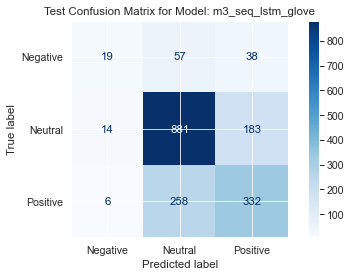

              precision    recall  f1-score   support

    Negative       0.49      0.17      0.25       114
     Neutral       0.74      0.82      0.77      1078
    Positive       0.60      0.56      0.58       596

    accuracy                           0.69      1788
   macro avg       0.61      0.51      0.53      1788
weighted avg       0.68      0.69      0.68      1788



In [81]:
# plot tes confusion matrix and classification report
cnf_matrix_test_m3 = plot_confusion('Test', y_test_piv.pred_class, 
                               y_test_hat_cl_m3_piv.pred_class,
                               m3.name)

## Compare Models

In [82]:
# create list of model names and confusion matrix results
models = [{'model_name': 'cnf_matrix_test_m0', 'model': cnf_matrix_test_m0}, 
          {'model_name': 'cnf_matrix_test_m1', 'model': cnf_matrix_test_m1},
          {'model_name': 'cnf_matrix_test_m2', 'model': cnf_matrix_test_m2},
          {'model_name': 'cnf_matrix_test_m3', 'model': cnf_matrix_test_m3}]

In [83]:
def ComputeStats(cm_array):
    accuracy = np.trace(cm_array)/np.sum(cm_array)
    neg_precision = cm_array[0,0]/sum(cm_array[:,0])
    neg_recall = cm_array[0,0]/sum(cm_array[0,:])
    pos_precision = cm_array[2,2]/sum(cm_array[:,2])
    pos_recall = cm_array[2,2]/sum(cm_array[2,:])
    return accuracy, neg_precision, neg_recall, pos_precision, pos_recall

In [84]:
# consolidate all models confusion matrix (test)
cm_test_compare = []
for model in models:
    model_stats = {}
    accuracy = neg_precision = neg_recall = pos_precision = pos_recall = 0
    accuracy, neg_precision, neg_recall, pos_precision, pos_recall = ComputeStats(model['model'])
    model_stats['model'] = model['model_name']
    model_stats['accuracy'] = accuracy   
    model_stats['neg_precision'] = neg_precision
    model_stats['neg_recall'] = neg_recall
    model_stats['pos_precision'] = pos_precision    
    model_stats['pos_recall'] = pos_recall   
    cm_test_compare.append(model_stats)

In [85]:
# compare key confusion matrix metrics between four models
pd.DataFrame(cm_test_compare)

,model,accuracy,neg_precision,neg_recall,pos_precision,pos_recall
0,cnf_matrix_test_m0,0.654,0.309,0.377,0.565,0.602
1,cnf_matrix_test_m1,0.669,0.500,0.096,0.582,0.478
2,cnf_matrix_test_m2,0.666,0.517,0.132,0.558,0.534
3,cnf_matrix_test_m3,0.689,0.487,0.167,0.600,0.557


**Analysis of Model Results**
- All four of these models are very similar, not sufficient.
- All four models are overfitting training data by 15-25% on accuracy scores.
- Recommending Model 3 due to higher accuracy, and combinations of precision/recall on both negative/positive; Also Model 3 has less overfitting.
- Did not use gridsearchCV but did try dozens of parameter settings, batch size, optimizers, learning rates and class weights. Out of time, so left best results as is.